In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Generate a base classification dataset with higher dimensionality, class imbalance, and complexity
X, y = make_classification(
    n_samples=2000,  # Increased sample size
    n_features=50,   # Increased feature dimensionality
    n_informative=15,  # More informative features
    n_redundant=10,    # More redundant features
    n_repeated=5,      # Add repeated features
    n_classes=2,       # Binary classification
    weights=[0.3, 0.7],  # Class imbalance
    hypercube=False,   # More complex feature space
    random_state=42
)

print(f"Generated dataset with {X.shape[0]} samples and {X.shape[1]} features.")
print(f"Class distribution: {np.bincount(y)}")

Generated dataset with 2000 samples and 50 features.
Class distribution: [ 597 1403]


In [ ]:
# Start with the original features
X_poly = np.copy(X)

# Add quadratic and sinusoidal interactions between features
for i in range(X.shape[1] - 1):
    for j in range(i + 1, X.shape[1]):
        X_poly = np.column_stack([
            X_poly, 
            X[:, i] ** 2 + X[:, j] ** 2,  # Quadratic interaction
            np.sin(X[:, i]) * np.cos(X[:, j])  # Non-linear interaction
        ])

print(f"Dataset after adding non-linear interactions: {X_poly.shape}")

Dataset after adding non-linear interactions: (2000, 2500)


In [4]:
# Add random noise to the features
noise = np.random.normal(0, 0.5, X_poly.shape)
X_noisy = X_poly + noise

print(f"Dataset after adding noise: {X_noisy.shape}")

Dataset after adding noise: (2000, 2500)


In [5]:
# Apply transformations: exponential and log
X_transformed = np.column_stack([
    X_noisy,
    np.exp(X_noisy[:, :5]),  # Exponential transformation of first 5 features
    np.log(np.abs(X_noisy[:, 5:10]) + 1)  # Log transformation of the next 5 features
])

print(f"Dataset after applying transformations: {X_transformed.shape}")

Dataset after applying transformations: (2000, 2510)


In [6]:
# Split the complex dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Testing set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

Training set: X_train shape = (1600, 2510), y_train shape = (1600,)
Testing set: X_test shape = (400, 2510), y_test shape = (400,)


In [7]:
# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")
print(f"Sample scaled X_train: {X_train_scaled[0]}")

Data preprocessing complete.
Sample scaled X_train: [ 0.3146126  -0.1471904   0.5829298  ...  0.25928752 -1.12655721
  0.59392789]


In [8]:
# Create a baseline model (no regularization)
baseline_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Baseline model created.")
baseline_model.summary()

Baseline model created.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       321,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,537 (1.23 MB)

 Trainable params: 321,537 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create a model with L1 regularization
l1_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    layers.Dense(1, activation='sigmoid')
])

l1_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("L1 regularization model created.")
l1_model.summary()

L1 regularization model created.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       321,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,537 (1.23 MB)

 Trainable params: 321,537 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Create a model with L2 regularization
l2_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

l2_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("L2 regularization model created.")
l2_model.summary()

L2 regularization model created.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       321,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,537 (1.23 MB)

 Trainable params: 321,537 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Create a model with Dropout regularization
dropout_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Dropout regularization model created.")
dropout_model.summary()

Dropout regularization model created.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │       321,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,537 (1.23 MB)

 Trainable params: 321,537 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Create a model with combined regularization (L1, L2, and Dropout)
combined_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
    ),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

combined_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Combined regularization model created.")
combined_model.summary()

Combined regularization model created.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       321,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,537 (1.23 MB)

 Trainable params: 321,537 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Define parameters for training
epochs = 100
batch_size = 32

# Dictionary to hold models
models = {
    'Baseline': baseline_model,
    'L1': l1_model,
    'L2': l2_model,
    'Dropout': dropout_model,
    'Combined': combined_model
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate on train and test sets
    train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

    # Calculate the difference between training and testing accuracy
    accuracy_difference = abs(train_accuracy - test_accuracy)

    results[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Accuracy Difference': accuracy_difference
    }

    print(f"{name} Model:")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Accuracy Difference: {accuracy_difference:.4f}")


Training Baseline model...
Baseline Model:
  Train Accuracy: 0.9500
  Test Accuracy: 0.7550
  Accuracy Difference: 0.1950

Training L1 model...
L1 Model:
  Train Accuracy: 0.9506
  Test Accuracy: 0.7475
  Accuracy Difference: 0.2031

Training L2 model...
L2 Model:
  Train Accuracy: 0.9569
  Test Accuracy: 0.7650
  Accuracy Difference: 0.1919

Training Dropout model...
Dropout Model:
  Train Accuracy: 0.9475
  Test Accuracy: 0.7675
  Accuracy Difference: 0.1800

Training Combined model...
Combined Model:
  Train Accuracy: 0.9294
  Test Accuracy: 0.7200
  Accuracy Difference: 0.2094


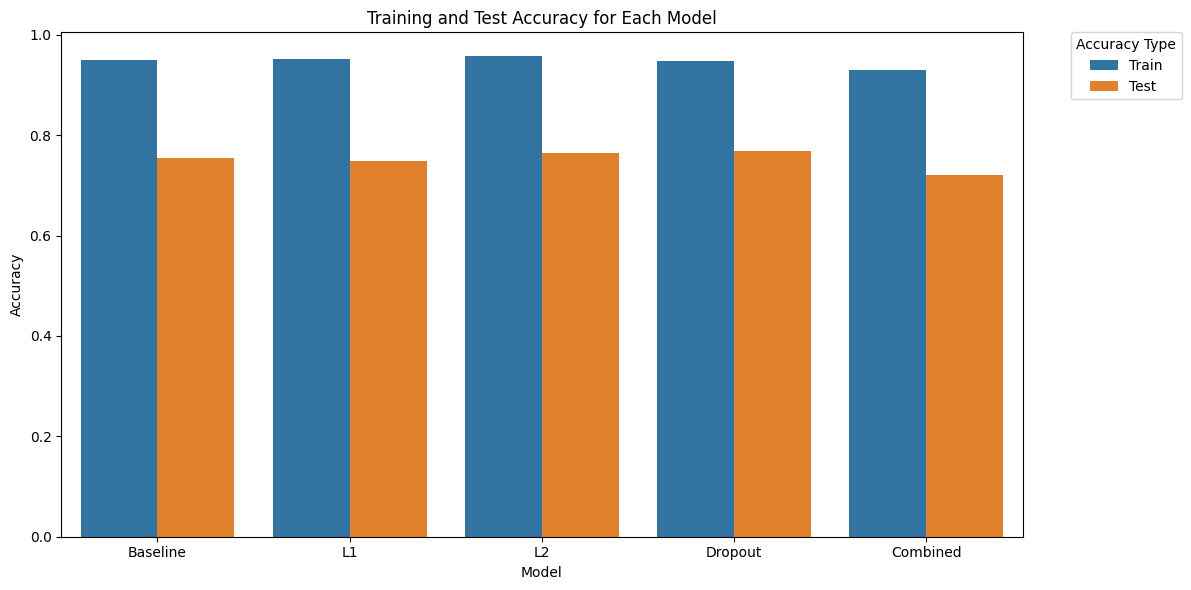

In [14]:
# Prepare data for visualization
data = []

for model_name, metrics in results.items():
    data.append({'Model': model_name, 'Accuracy': metrics['Train Accuracy'], 'Type': 'Train'})
    data.append({'Model': model_name, 'Accuracy': metrics['Test Accuracy'], 'Type': 'Test'})

df = pd.DataFrame(data)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Type', data=df)
plt.title('Training and Test Accuracy for Each Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Place the legend outside the plot to avoid overlapping
plt.legend(title='Accuracy Type', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()  # Ensure everything fits within the figure area
plt.show()